In [ ]:
# laplace-CAN-paper-figures.ipynb
#
# Bryan Daniels

Simulating a continuous attractor network (CAN) that matches with the Laplace
transform picture of Howard et al. 2018.  We have:

   - Units connected in a 1-D topology with marginally stable activity patterns
     that consist of an "edge" at any location along the line
   - The edge moves with speed that scales as $1/t$

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize

from laplace_network import asymmetric_laplace_network,gaussian_laplace_network,find_edge_location
import laplace_CAN_figures as lf

from importlib import reload
reload(lf)

<module 'laplace_CAN_figures' from '/Users/bdaniel6/Dropbox (ASU)/Research/laplace-decisions/code/laplace_CAN_figures.py'>

# Demonstrate exponential decay using asymmetric interaction kernel

In [2]:
from laplace_network import asymmetric_edge_states

In [9]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation = 100 # number of units in each population
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z 
delta_z = 1/4 #1/8 #1/4  
n_0_asymmetric = Npopulation/2 
t_0_asymmetric = 10 

# scale of interaction strength between neighbors
J = 2 #4 # 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n 
J_bump_edge_max = 5 # 10 # to avoid instability
J_bump_edge_scale_factor_asymmetric = 0.65 # 0.65 fit by eye for asymmetric edge
J_bump_edge = [ -J_bump_edge_scale_factor_asymmetric*min(1./t_0_asymmetric*1./delta_z*np.exp(-delta_z*(n-n_0_asymmetric)),
                                              J_bump_edge_max) for n in range(Npopulation) ] 
# 2024/1/26 set sigma to 1 for all synapses except edge->edge
sigma_edge = 0.5 #0.25 #0.5 
sigma_other = 1

net_asymmetric = asymmetric_laplace_network(
                      Npopulation=Npopulation,
                      J=J,
                      delta_z=delta_z,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      sigma_edge=sigma_edge,
                      sigma_other=sigma_other)

zero_velocity_asymmetric_edge_Jmat: edge_shift = 0.1256244214584455


In [10]:
# run simulation

noise_var = 1e-6 #1e-2 #0. # strength of noise (variance added per unit time)
i_final = 7 #6 #5 #(t increases exponentially with i) 
t_final = t_0_asymmetric + 2**(i_final-1)
delta_t = 0.01 #0.001 
seed = 12345

# start with edge state at location n_0 at time t_0
edge_t = t_0_asymmetric 
initial_guess_edge = net_asymmetric.J*(2*asymmetric_edge_states(np.arange(0,Npopulation),edge_t,delta_z=delta_z,n_0=n_0_asymmetric)-1)
edge_state = net_asymmetric.find_edge_state(n_0_asymmetric,
                                 initial_guess_edge=initial_guess_edge,
                                 method='translate')

# simulate dynamics
states_asymmetric = net_asymmetric.simulate_dynamics(edge_state,
                               t_final-t_0_asymmetric,
                               noise_var,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states_asymmetric.index = states_asymmetric.index + t_0_asymmetric

Text(0, 0.5, 'Neural state')

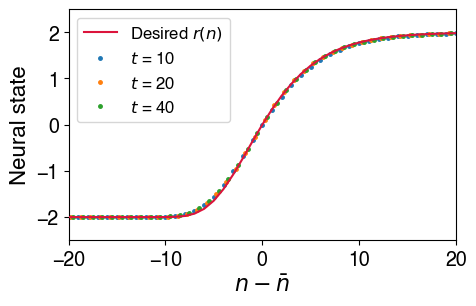

In [11]:
# compare simulated shape of edge to desired shape

plt.figure(figsize=(5,3))

nList = np.arange(0,net_asymmetric.Npopulation)
desired_edge_shape = net_asymmetric.J*(2*asymmetric_edge_states(nList,t_0_asymmetric,
                                                                delta_z=delta_z,
                                                                n_0=n_0_asymmetric,
                                                                t_0=t_0_asymmetric)-1)
desired_edge_offset = find_edge_location(desired_edge_shape)[0]
plt.plot(nList-desired_edge_offset,desired_edge_shape,
         label='Desired $r(n)$',
         color='crimson',
         zorder=+10)

for t in [t_0_asymmetric,
          t_0_asymmetric*2,
          t_0_asymmetric*4,
         ]:
    edge_offset = np.sort(abs(find_edge_location(states_asymmetric.loc[t])))[0]
    plt.plot(nList - edge_offset,
             states_asymmetric.loc[t]['Neuron 0':'Neuron {}'.format(Npopulation-1)],
                 '.',label="$t$ = {}".format(int(t)),lw=1,ms=5)
plt.axis(xmin=-5/net_asymmetric.delta_z,
         xmax=5/net_asymmetric.delta_z,
         ymin=-net_asymmetric.J-0.5,
         ymax=net_asymmetric.J+0.5)
plt.legend()
plt.xlabel('$n - \\bar n$')
plt.ylabel('Neural state')

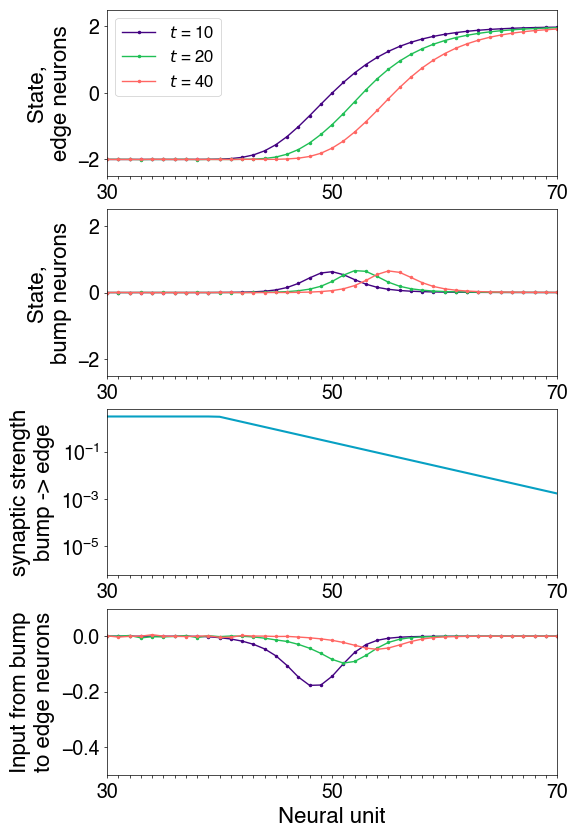

In [20]:
lf.translation_simulation_plot(net_asymmetric,states_asymmetric,states_asymmetric,
                               num_neurons_scale=5/net_asymmetric.delta_z)
#plt.savefig('231117_self_sustained_edge_decaying_velocity.pdf')

In [42]:
reload(lf)

<module 'laplace_CAN_figures' from '/Users/bdaniel6/Dropbox (ASU)/Research/laplace-decisions/code/laplace_CAN_figures.py'>

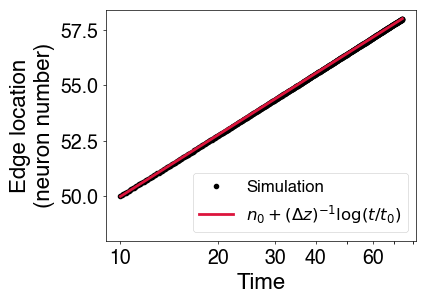

In [43]:
lf.edge_location_plot(net_asymmetric,states_asymmetric,n_0_asymmetric,t_0_asymmetric,delta_z)
plt.xticks(t_0_asymmetric*np.array([1,2,3,4,6]),t_0_asymmetric*np.array([1,2,3,4,6]));

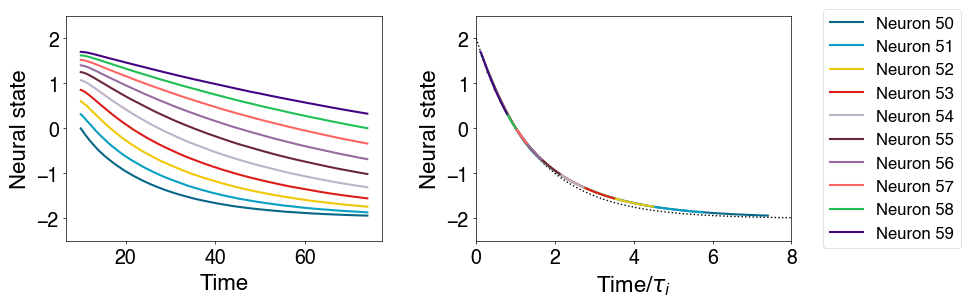

In [22]:
t_max = 80

lf.time_rescaling_plot(states_asymmetric,n_0_asymmetric,t_0_asymmetric,delta_z,t_max=t_max,
                       state_min=-net_asymmetric.J-0.5,state_max=net_asymmetric.J+0.5,
                       delta_n=int(1/delta_z/4))

# also plot analytical result as dotted line
analytical_times = np.linspace(0,t_max,1000)
plt.plot(analytical_times/t_0_asymmetric,
         net_asymmetric.J*(2*asymmetric_edge_states(n_0_asymmetric,analytical_times,
                                                 delta_z=delta_z,n_0=n_0_asymmetric,t_0=t_0_asymmetric)-1),
         'k:',
         zorder=-10,
         lw=1,)
#plt.savefig('240118_firing_rate_vs_time.pdf')

# Demonstrate geometric series of timescales using symmetric kernel

In [23]:
def states2rates(states):
    return 0.5*(1.+np.tanh(states))

In [24]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

Npopulation_symmetric = 100 # number of units in each population
# delta_z is the conversion unit from distance measured in number of neurons 
# to the relevant output variable z 
delta_z = 1/4 
# scale of interaction strength between neighbors
J = 2 
# constant interaction from edge neurons to corresponding bump neurons
J_edge_bump = 1
# strength of feedback from bump to edge neurons varies with n
t_0_symmetric = 10
n_0_symmetric = Npopulation_symmetric/2 
J_bump_edge_max = 10 # to avoid instability
J_bump_edge_scale_factor_symmetric = 1 
J_bump_edge = [ -J_bump_edge_scale_factor_symmetric*min(1./t_0_symmetric*1./delta_z*np.exp(-delta_z*(n-n_0_symmetric)),
                                              J_bump_edge_max) for n in range(Npopulation_symmetric) ]
kernel_width = 2 
sigma = 1. 

net_symmetric = gaussian_laplace_network(
                      Npopulation=Npopulation_symmetric,
                      J=J,
                      J_edge_bump=J_edge_bump,
                      J_bump_edge=J_bump_edge,
                      kernel_width=kernel_width,
                      sigma=sigma)

In [25]:
# run simulation

noise_var = 1e-6 #1e-4 # strength of noise (variance added per unit time)
i_final = 7 #6 #(t increases exponentially with i) 
t_final = t_0_symmetric + 2**(i_final-1)
delta_t = 0.01 #0.001
seed = 12345

# start with edge state at location n_0 at time t_0
edge_state = net_symmetric.find_edge_state(n_0_symmetric)
    
# simulate dynamics
states_symmetric = net_symmetric.simulate_dynamics(edge_state,
                               t_final-t_0_symmetric,
                               noise_var,
                               additional_input=None,
                               seed=seed,
                               delta_t=delta_t)
# shift times to start at t_start
states_symmetric.index = states_symmetric.index + t_0_symmetric
rates_symmetric = states2rates(states_symmetric)

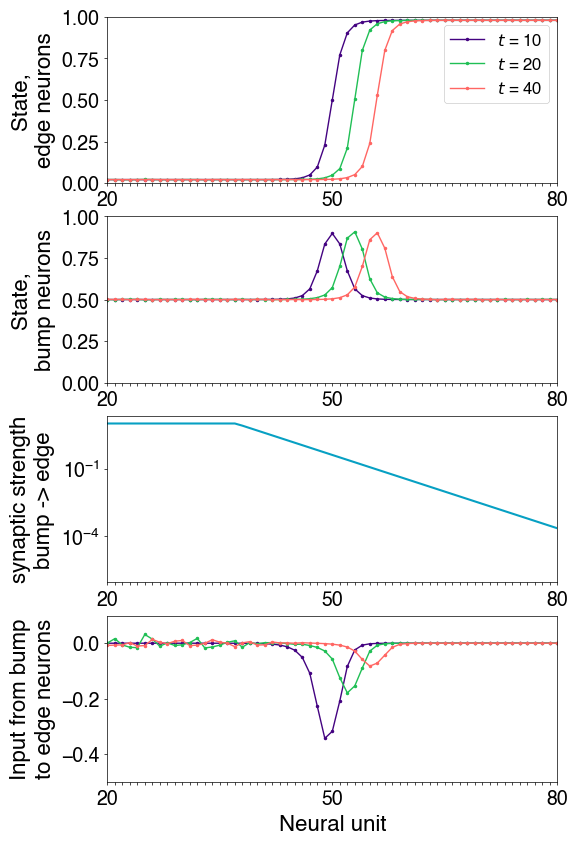

In [26]:
lf.translation_simulation_plot(net_symmetric,rates_symmetric,states_symmetric,
                            state_min=0,state_max=1)

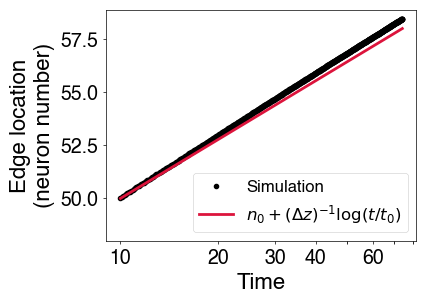

In [44]:
lf.edge_location_plot(net_symmetric,states_symmetric,n_0_symmetric,t_0_symmetric,delta_z)
plt.xticks(t_0_symmetric*np.array([1,2,3,4,6]),t_0_symmetric*np.array([1,2,3,4,6]));
plt.yticks(

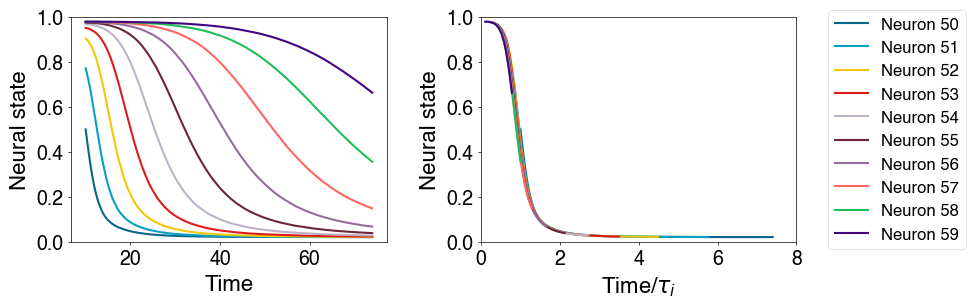

In [27]:
lf.time_rescaling_plot(rates_symmetric,n_0_symmetric,t_0_symmetric,delta_z,
                   state_min=0,state_max=1,
                   delta_n=int(1/delta_z/4))